In [11]:
import kaggle
import pandas
import os
import re
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import os
import kaggle

from torchvision.models import efficientnet_b0
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np

from model.model import efficient_net_b0
from misc.train import train_model
from misc.plotting import get_examples
from misc.data_preprocessing import CustomImageDataset, get_statistics, download_data, create_dataloaders, get_dataloader_example


In [12]:
path = './data/'
download_data(path)

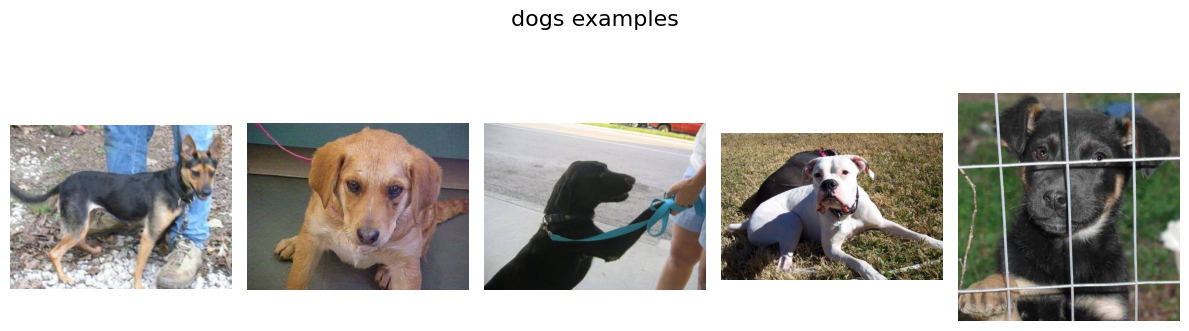

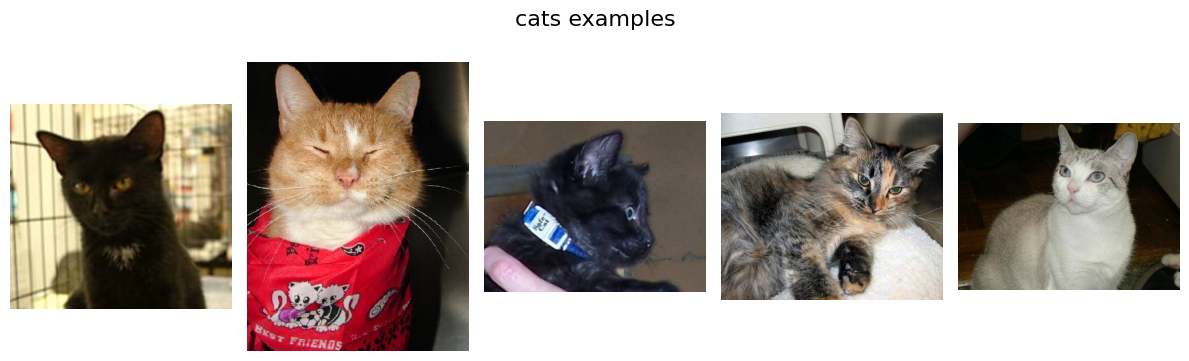

In [13]:
get_examples(5)

In [14]:
# Train Statistics
get_statistics('./data/training_set/training_set/')

# Test Statistics
get_statistics('./data/test_set/test_set/')

Number of dogs: 4005
Most common dogs image shapes:
width: 500, height: 374, count: 450
width: 499, height: 375, count: 423
width: 375, height: 499, count: 45

Number of cats: 4000
Most common cats image shapes:
width: 499, height: 375, count: 506
width: 500, height: 374, count: 490
width: 499, height: 333, count: 48

Directory not found for .DS_Store: ./data/training_set/training_set/.DS_Store/
Number of dogs: 4005
Most common dogs image shapes:
width: 500, height: 374, count: 450
width: 499, height: 375, count: 423
width: 375, height: 499, count: 45

Number of cats: 4000
Most common cats image shapes:
width: 499, height: 375, count: 506
width: 500, height: 374, count: 490
width: 499, height: 333, count: 48

Total Count: 8005


Images Shape: torch.Size([2, 3, 512, 512])
Labels Shape: torch.Size([2, 2])
Example Image:


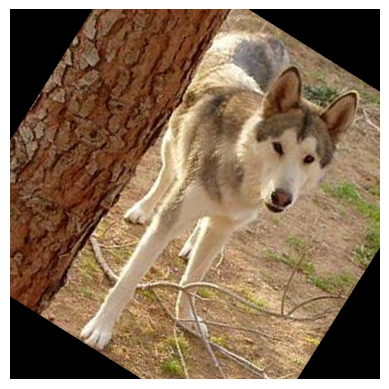

Image Class: tensor([1., 0.])


In [15]:
train_loader, val_loader = create_dataloaders()
get_dataloader_example(train_loader)

In [24]:
# Our efficient net model
model = efficient_net_b0()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total number of parameters in our EfficientNet-B0: {total_params}')
 
# Built in pytorch efficient net model
model = efficientnet_b0(num_classes=2, pretrained=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total number of parameters in official EfficientNet-B0: {total_params}')

Total number of parameters in our EfficientNet-B0: 416896
Total number of parameters in official EfficientNet-B0: 4010110


/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model_path = './model/model_weights.pth'

model = efficient_net_b0()

pytorch_total_params = sum(p.numel() for p in model.parameters())
print('Number of Parameters:', pytorch_total_params)

optimizer = torch.optim.Adam(
	params=model.parameters(),
	lr=1e-4
)

scheduler = ReduceLROnPlateau(
	optimizer,
	'min',
	factor=0.1,
	min_lr=1e-6
)

train_model(
	model,
	optimizer,
	scheduler=scheduler,
	train_loader=train_loader,
	val_loader=val_loader,
	model_path=model_path,
	epochs=200,
	patience=25,
	threshold=1e-4
)

Number of Parameters: 416896


  0%|                                                  | 0/3202 [00:04<?, ?it/s]


KeyboardInterrupt: 